## Modelo parcela de nuvem

#### Projeto de Iniciação Cientifica, PRP - USP  
##### Instituto de Física - Universidade de São Paulo

 **Bolsista: Jéssica Karina Moraes Gambôa**  
 **Orientador: Prof. Dr. Henrique de Melo Jorge Barbosa**

Este Jupyter Notebook foi feito como parte do projeto de iniciação científica. Nele está a  implementação do modelo de parcela de nuvem utilizado para descrever o crescimento de uma população de aerossóis resolvendo númericamente um sistema de equações diferenciais acopladas. 

___
##### Sumário  
> [1. Funções Termodinâmicas](#s1)  
&emsp;Funções termodinâmicas utilizadas no modelo de parcela e seus respectivos plot's.  
> [2. Funções Teoria de $\mathbf{\kappa}$ - Köhler](#s2)  
&emsp;Implementação das funções da teoria de Köhler e seus respectivos plot's.  
> [3. Distribuições](#s3) 
___

<a class="anchor" id="s1"></a>
## 1. Funções Termodinâmicas

Abaixo são importadas as bibliotecas utilizadas na implementação

#### Bibliotecas necessárias:

In [204]:
import numpy as np
import math as m
from scipy.integrate import odeint
from scipy.optimize import fminbound
from scipy.optimize import fsolve
import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.special import erfc
from scipy.interpolate import interp1d
from numba.pycc import CC
from numba import jit, njit, vectorize
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Aqui são definidas as constantes físicas utilizadas.

#### Constantes:

In [205]:
g = 9.8 # Gravitational const, m/sˆ2
Cp = 1004.0 # Specifc heat of dry air, J/Kg
L = 2.25e6 # Latent heat of condensation, J/kg
rho_w = 1000.0 # Density of water, kg/mˆ3
rho_a = 1.1839 # Air density, kg/m3, at 1 atm or 101.325 kPa
R = 8.314 # Universal gas constant in J/mol/K
Mw = 18.0 / 1e3 # Molecular weight of water in kg/mol
Ma = 28.9 / 1e3 # Molecular weight of dry air
Rd = R / Ma # Gas constant for dry air in J/kg/K
Rv = R / Mw # Gas constant for water vapor in J/kg/K
ac = 1 # Condensation coefficient, dimensionless
at = 0.96 # Thermal accomodation coefficient, dimensionless
epsilon = Mw/Ma # dimensionless
nsv = 7 # number of state variables

[[Seinfeld and Pandis 2016](S&P)] defini na pg. 723 - seção 17.3 a difusividade de vapor d'àgua $D_v$:  

\begin{equation}
    \begin{cases}
        D_v = \frac{0.211}{p} \left( \frac{T}{273} \right)^{1.94} \quad cm^{2}s^{-1}\\
        D'_{v} = D_{v}\bigg/ \left[ 1+ \frac{2D_{v}}{a_c D}\sqrt{\frac{2\pi M_w}{RT}} \right] \quad cm^{2}s^{-1} 
    \end{cases}
    \label{eq1}
\end{equation}

onde, $D'_v$ é a forma modificada para efeitos não contínuos.

In [206]:
def Dv (T, D, P, accom=ac):
    P_atm = P * 1.0123e-5 # Pa -> atm
    Dv_cont = 1e-4 * (0.211 / P_atm) *((T / 273)**1.94)
    denom = 1.0 + (((2*Dv_cont) / (accom * D)) * np.sqrt((2.0 * np.pi * Mw) / (R * T)))
    Dv = Dv_cont/denom
    return Dv

Reprodução da Fig.17.11 apresentada na pg.723 de [[Seinfeld and Pandis 2016](S&P)]:

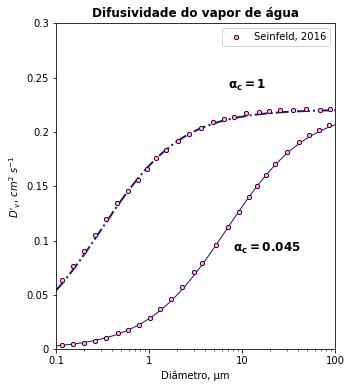

In [207]:
T = 283. # K
P = 101325 # pa
D = np.linspace(0.1e-6, 100e-6, 10000) # m
#Calcula
Dv1 = Dv(T, D, P, 0.045)
Dv2 = Dv(T, D, P, 1)

# Config. plot
fig = plt.figure()
fig.set_size_inches(5,6)
ax = plt.gca()
ax.set_xscale('log')
scale_x = 1e-6 # meters to micrometers
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
ax.xaxis.set_major_formatter(ticks_x)
scale_y = 1e-4 # m²/s to cm²/s
ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
plt.xlabel('Diâmetro, μm')
plt.ylabel("$D'_{v}$, $cm^{2}$ $s^{-1}$ ")
plt.title("Difusividade do vapor de água", fontsize = 12, fontweight="bold")
plt.axis(xmin=0.1*1e-6,xmax=100*1e-6,ymin=0, ymax=0.3e-4)
# Anotation
label_Dv1= r'$\bf{\alpha_c = 1}$'
plt.annotate(label_Dv1, (7e-6, 0.24e-4), size=12,)   
label_Dv2= r'$\bf{\alpha_c = 0.045}$'
plt.annotate(label_Dv2, (8e-6, 0.09e-4), size=12)
# Plot
plt.plot(D, Dv1, color='#191970',lw=1)
plt.plot(D, Dv2, color='#191970', ls='dashdot',lw=2)
# Comparação
data = np.genfromtxt("cópia de s_17_11_1.csv", delimiter=";", names=["x", "y"])
plt.plot(data['x'], data['y'], '8', ms = 5, mec = '#4d0039', mfc = '#ffb3ec', label='Seinfeld, 2016')
data = np.genfromtxt("cópia de s_17_11_2.csv", delimiter=";", names=["x", "y"])
plt.plot(data['x'], data['y'], '8', ms = 5, mec = '#4d0039', mfc = '#ffb3ec')
plt.legend()
plt.show()

[[Seinfeld and Pandis 2016](S&P)] defini na pg. 726 a condutividade termica do ar $k_a$:  

\begin{equation}
    \begin{cases}
        k_{a} = 10^{-3}(4.39 + 0.071T) \quad Jm^{-1}s^{-1}K^{-1}\\
        k'_{a} = k_{a}\bigg/ \left[ 1+ \frac{2 k_{a}}{a_T D \rho c_p}\sqrt{\frac{2\pi M_a}{RT}} \right] \quad Jm^{-1}s^{-1}K^{-1} 
    \end{cases}
    \label{eq2}
\end{equation}

onde, $k'_a$ é a forma modificada para efeitos não contínuos.

In [208]:
def ka (T, rho, D, accom=at):
    ka_cont = 1e-3 * (4.39 + 0.071 * T)
    denom = 1.0  + (((2.0 * ka_cont) / (accom * D * rho * Cp)) * 
                        np.sqrt((2.0 * np.pi * Ma) / (R * T)))
    ka = ka_cont/denom
    return ka

Na pg. 709 de [[Seinfeld and Pandis 2016](S&P)] é definido os coeficientes e o calculo para obter a pressão de vapor de saturação da água sobre a água pura: 

\begin{equation}
    e_{s} = a_0 + a_1T_c + a_2T_{c}^{2} + a_3T_{c}^{3} + a_4T_{c}^{4}+ a_5T_{c}^{5} + a_6T_{c}^{6} \quad mbar
    \label{eq3}
\end{equation}

In [209]:
def es(T):
    Tc = T - 273
    A = [6.107799610e0,
         4.436518521e-1,
         1.428945805e-2,
         2.650648471e-4,
         3.031240396e-6,
         2.034080948e-8,
         6.136820929e-11,
        ]
    vp = A[-1] * Tc
    for ai in reversed(A[1:-1]):
        vp = (vp + ai) * Tc
    vp += A[0]
    es = vp * 100 # mbar -> Pa   
    return es

Plot para vizualizar o comportamento da pressão de vapor com a variação da temperatura.

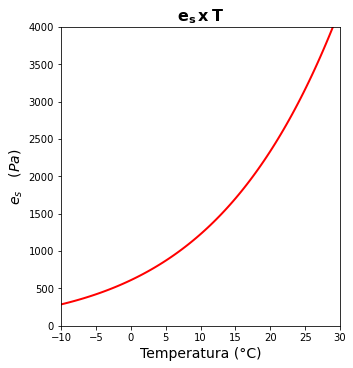

In [210]:
T = np.linspace(263,303,100)
e_s = es(T)
# Config. plot
fig = plt.figure()
fig.set_size_inches(5,5.5)
ax = plt.gca()
plt.xlabel('Temperatura (°C)', fontsize = 14)
plt.ylabel(r"$e_{s}\quad (Pa)$", fontsize = 14)
plt.title(r"$\bf{e_{s} \,x\, T}$", fontsize = 16, fontweight="bold")
plt.axis(xmin=-10,xmax=30,ymin=0, ymax=40e2)
#Plot
plt.plot(T-273, e_s, '-r', lw=2)
plt.show()

A tensão superficial da água $\sigma_w$ é apresentada na pg. 701 de [[Seinfeld and Pandis 2016](#S&P)]: 

\begin{equation}
    \sigma_{w} = 0.0761 - 1.55\times10^{-4}(T_{C} - 273) \quad Jm^{-2}
    \label{eq4}
\end{equation}

Entretanto, [[Pruppacher and Klett 2011 ](#P&K)] na pg.130 (Eq.5-12) propõe que a tensão superficial seja calculada pela seguinte relação: 

\begin{equation}
    \sigma_{w} = \sum_{n=0}^{6}a_nT^{n}\quad erg\,cm^{-2}
    \label{eq5}
\end{equation} 

Os coeficientes utilizados no calculos são fornecidos pelo autor logo abaixo da equação.

In [211]:
def sigma_w (T, mode="Pruppacher"):
    if mode=="Pruppacher": 
        Tc = T - 273.15 # K -> ºC
        A = [75.93, # a0
             0.115, # a1
             6.818e-2, # a2
             6.511e-3, # a3
             2.933e-4, # a4
             6.283e-6, # a5
             5.285e-8, # a6
             ]
        sigma_w = A[-1] * Tc
        for ai in reversed(A[1:-1]):
            sigma_w = (sigma_w + ai) * Tc
        sigma_w += A[0]
        sigma_w = sigma_w * 1e-3 # ergs/cm² -> J/m²
        
    elif mode=='Seinfeld':
        sigma_w = 0.0761 - 1.55e-4 * (T - 273)
    return sigma_w

Abaixo foi feito um plot de comparação entre as duas definições:

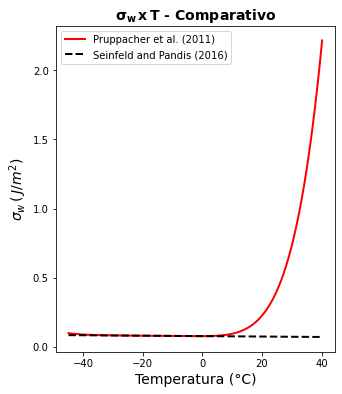

In [212]:
T = np.linspace(228.15,313.15,100)
sigma_P = sigma_w(T, mode="Pruppacher")
sigma_S = sigma_w(T, mode='Seinfeld')
# Config. plot
fig=plt.figure()
fig.set_size_inches(5,6)

plt.xlabel('Temperatura (°C)', fontsize = 14)
plt.ylabel(r"${\sigma_{w}}\, (\,J/m^{2})$", fontsize = 14)
plt.title(r"$\bf{\sigma_{w} \,x\, T}$ - Comparativo", fontsize = 14, fontweight="bold")
#plt.axis(xmin=-10,xmax=30,ymin=0, ymax=40e2)
#Plot
plt.plot(T-273, sigma_P, '-r', lw=2, label="Pruppacher et al. (2011)")
plt.plot(T-273, sigma_S, '--k', lw=2, label="Seinfeld and Pandis (2016)")
plt.legend()
plt.savefig("Tensao_sup", dpi=600, facecolor='w')
plt.show()

Na pg. 67 de [[Wallace and Hobbs 2011](#W&H)] é definida a temperatura virtual, e mais adiante na pg. 80 uma simplificação da equação é apresentada como segue:  

\begin{equation}
    T_v \approx \frac{T}{1 - \frac{e_s}{p}(1 - \varepsilon)} \Rightarrow \, T_v \approx T(1 + 0.61w)
    \label{eq6}
\end{equation}  

sendo $w$ a taxa de mistura e $\varepsilon=M_w/M_a=0.622$.

In [213]:
def Tv (T,wv,s):
    wv_sat = wv / (s + 1.0) 
    Tv = (1.0 + 0.61 * wv_sat) * T 
    return Tv

A pressão parcial de vapor de água é dada por [[Seinfeld and Pandis 2016](#S&P)] apresentada na pg. 727:  

\begin{equation}
    1 + s_v = \frac{e}{e_s} \Rightarrow \, e = e_s(1 + s_v)
    \label{eq7}
\end{equation}

onde $s_v$ é a supersaturação dada pela teoria de $\kappa$-Köler.

In [214]:
def e (s,T):
    e = (1.0 + s) * es(T)
    return e

A densidade do ar foi calculada a partir de:

In [215]:
def rho_air (P,T,s,wv,dry=True):
    if dry:
        rho_air_dry = (P - e(s,T)) / (Rd * T) 
        rho_air = rho_air_dry
    else: 
        rho_air = P / (Rd * Tv(T,wv,s)) 
    
    return rho_air

De acordo com [[Pruppacher and Klett 2011 ](#P&K)] a densidade da água varia com a temperatura. Para o intervalo de temperatura $0°C\,\le\,T\,\le\,100°C$ a densidade da água pode ser calculada como segue:  

\begin{equation}
    10^3 \rho_w =\frac{A_0 + A_1T_c + A_2T_{c}^{2} + A_3T_{c}^{3} + A_4T_{c}^{4} + A_5T_{c}^{5}}{1+BT_c} \quad g\, cm^3
    \label{eq8}
\end{equation}  

os valores de A e B são fornecidos por [[Pruppacher and Klett 2011 ](#P&K)] na pg. 87 e a temperatura $T$ usada aqui é dada em $°C$.

In [216]:
def rho_water (T):
    t = T - 273.15 # Temperature in Celsius
    A0 = 999.8396 # unit: kg/mˆ3
    A1 = 18.224944 # unit: kg/(mˆ3 C)
    A2 = -7.92221e-3 # unit: kg/(mˆ3 Cˆ2)
    A3 = -55.44846e-6 # unit: kg/(mˆ3 Cˆ3)
    A4 = 149.7562e-9 # unit: kg/(mˆ3 Cˆ4)
    A5 = -393.2952e-12 # unit: kg/(mˆ3 Cˆ4)
    B = 18.159725e-3 # unit: 1/C
    
    rho_water = (A0 + A1*t + A2*(t**2) + A3*(t**3) + A4*(t**4) + A5*(t**5))/(1+B*t) # kg/mˆ3
    return rho_water

___
<a class="anchor" id="s2"></a>
## 2. Funções Teoria de $\mathbf{\kappa}$ - Köhler

Alguns valores para o parametro de higroscopicidade $\kappa$ dados por [[Seinfeld and Pandis 2016](#S&P)] na pg. 734

In [217]:
# Hygroscopicity parameters for some substancies
kappas = {'NaCl' : 1.28, 'CaSO_4' : 0.002, 'Ca(NO_3)_2' : 0.51, 
              'MgSO_4' : 0.8, 'KCl' : 0.9, 'NaNO_3' : 0.88, 
              '(NH_4)_2 SO_4' : 0.61, 'NH_4NO_3' : 0.67}

A taxa de saturação de acordo com a teoria de $\kappa$-Köhler é definida por [[Seinfeld and Pandis 2016](#S&P)] na pg. 734.

\begin{equation}
    S(D) = \frac{D^3 - D_{d}^{3}}{D^3 - D_{d}^{3}(1 - \kappa)}exp\left ( \dfrac{4M_w \sigma_w}{RT \rho_{w}D} \right ) 
    \label{eq9}
\end{equation}

onde $D$ e $D_d$ são respectivamente, o diâmetro da particula e o diâmetro seco da particula de aerossol.  

A supersaturação é de definida como:

\begin{equation}
    s(D) = \left (S(D) -1\right ) \times 100\%
    \label{eq10}
\end{equation}



In [218]:
def seq (D, Dd, T, kappa):
    A = (D**3 - Dd**3) / (D**3 - (Dd**3 * (1 - kappa)))
    B = (4.0 * sigma_w(T) * Mw) / (R * T * rho_water(T) * D)
    seq = A * np.exp(B) -1
    return seq

In [219]:
def Seq (D, Dd, T, kappa):
    A = (D**3 - Dd**3) / (D**3 - (Dd**3 * (1 - kappa)))
    B = (4.0 * sigma_w(T) * Mw) / (R * T * rho_water(T) * D)
    Seq = A * np.exp(B)
    return Seq

In [220]:
# Supersaturação usando sigma_w def. por Seinfeld (2016)
def ss(D, Dd, T, kappa): 
    A = (D**3 - Dd**3) / (D**3 - (Dd**3 * (1 - kappa)))
    B = (4.0 * sigma_w(T,mode='Seinfeld') * Mw) / (R * T * rho_water(T) * D)
    seq = A * np.exp(B) -1
    return seq

A partir das implementações foi possivel reproduzir as curvas de Köhler, fig. 3.1 da pg. 56 de [[Araujo 2017](#Araujo)].

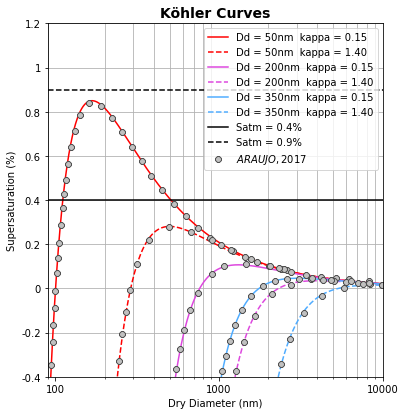

In [221]:
kappas =[0.15,1.4]
Dds =[50e-9,200e-9,350e-9]  
T = 298.15 # K
Satm = 1.004 #(Saturation = RH = 100.4%, SuperSat = 0.4%)
satm1 = 0.4e-2
satm2 = 0.9e-2
# wet diameters:
Dp1 = np.linspace(1e-8,1e-5, 1000000)
Dp3 = np.linspace(3e-7,1e-5, 1000000)
Dp5 = np.linspace(3.5e-7,1e-5, 1000000)
# Supersaturations (%):
s1 = ss(Dp1, Dds[0], T, kappas[0])
s2 = ss(Dp1, Dds[0], T, kappas[1])
s3 = ss(Dp3, Dds[1], T, kappas[0])
s4 = ss(Dp3, Dds[1], T, kappas[1])
s5 = ss(Dp5, Dds[2], T, kappas[0])
s6 = ss(Dp5, Dds[2], T, kappas[1])
# Adjusting scales and display limits:
fig = plt.figure()
fig.set_size_inches(6,6.5)
ax = plt.gca()
plt.axis(xmin=0.9e-7,xmax=1e-5,ymin=-0.004, ymax=0.012)
ax.set_xscale('log')
scale_x = 1e-9 # meters to nanometers
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
ax.xaxis.set_major_formatter(ticks_x)
scale_y = 1e-2 # to %
ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
plt.title("Köhler Curves",  fontsize = 14, fontweight="bold")
plt.xlabel('Dry Diameter (nm)')
plt.ylabel("Supersaturation (%)")
plt.grid(True, which="both", axis='x')
plt.grid()
# Plots:
plt.plot(Dp1, s1, color= '#FF0000', markersize=20, label="Dd = 50nm  kappa = 0.15")
plt.plot(Dp1, s2, ls = '--', color= '#FF0000', markersize=10, label="Dd = 50nm  kappa = 1.40")
plt.plot(Dp3, s3, color= '#dd47de', markersize=10, label="Dd = 200nm  kappa = 0.15")
plt.plot(Dp3, s4, ls = '--', color= '#dd47de', markersize=10, label="Dd = 200nm  kappa = 1.40")
plt.plot(Dp5, s5, color= '#4facff', markersize=1, label="Dd = 350nm  kappa = 0.15")
plt.plot(Dp5, s6, ls = '--', color= '#4facff', markersize=10, label="Dd = 350nm  kappa = 1.40")
plt.axhline(y = satm1, color = 'black', label="Satm = 0.4%")  
plt.axhline(y = satm2, color = 'black', ls = '--', label="Satm = 0.9%")
## VALIDAÇÃO
data1 = np.genfromtxt("vermelho1.csv", delimiter=";", names=["x", "y"])
plt.plot(data1['x'], data1['y'], '8', ms = 6, mec = '#4F4F4F', mfc = '#C0C0C0', label='$ARAUJO, 2017$')
data2 = np.genfromtxt("vermelho2.csv", delimiter=";", names=["x", "y"])
plt.plot(data2['x'], data2['y'], '8', ms = 5.5, mec = '#4F4F4F', mfc = '#C0C0C0')
data3 = np.genfromtxt("verde1.csv", delimiter=";", names=["x", "y"])
plt.plot(data3['x'], data3['y'], '8', ms = 5.5, mec = '#4F4F4F', mfc = '#C0C0C0')
data4 = np.genfromtxt("azul1.csv", delimiter=";", names=["x", "y"])
plt.plot(data4['x'], data4['y'], '8', ms = 5.5, mec = '#4F4F4F', mfc = '#C0C0C0')
data5 = np.genfromtxt("verde2.csv", delimiter=";", names=["x", "y"])
plt.plot(data5['x'], data5['y'], '8', ms = 5.5, mec = '#4F4F4F', mfc = '#C0C0C0')
data6 = np.genfromtxt("azul2.csv", delimiter=";", names=["x", "y"])
plt.plot(data6['x'], data6['y'], '8', ms = 5.5, mec = '#4F4F4F', mfc = '#C0C0C0')
plt.legend(loc='upper right')
#plt.savefig("c_kohler", dpi=600, facecolor='w')
plt.show()

---
Abaixo é reproduzido a fig. 17.5 de [[Seinfeld and Pandis 2016](#S&P)] apresentada na pg. 714: 

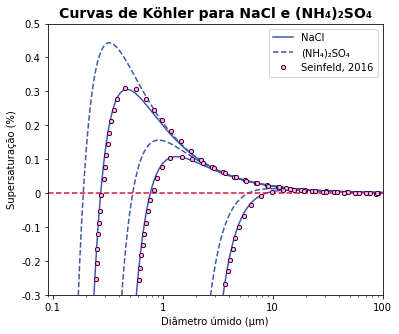

In [222]:
kappa1 = 1.28 # NaCl
kappa2 = 0.61 # (NH₄)₂SO₄
T = 293. # K
Dd1 = 0.05e-6
Dd2 = 0.1e-6
Dd3 = 0.5e-6
Dps = np.linspace(0.05e-6, 1e-4, 100000)
Dps1 = np.linspace(1.0e-6, 1e-4, 100000)
# supersaturation (saturaton - 1.0)
# NaCl
s1 = ss(Dps, Dd1, T, kappa1) 
s2 = ss(Dps, Dd2, T, kappa1)
s3 = ss(Dps, Dd3, T, kappa1)
# (NH₄)₂SO₄
s4 = ss(Dps, Dd1, T, kappa2)
s5 = ss(Dps, Dd2, T, kappa2)
s6 = ss(Dps1, Dd3, T, kappa2)

fig = plt.figure()
fig.set_size_inches(6,5)
ax = plt.gca()
ax.set_xscale('log')
ax.set_ylim(-0.003, 0.005)
ax.set_xlim([0.9e-7,1e-4]) 
scale_x = 1e-6 # meters to micrometers
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
ax.xaxis.set_major_formatter(ticks_x)
scale_y = 1e-2 # to %
ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
plt.title("Curvas de Köhler para NaCl e (NH₄)₂SO₄", fontsize = 14, fontweight="bold")
plt.xlabel('Diâmetro úmido (µm)')
plt.ylabel("Supersaturação (%)")
plt.plot(Dps, s1, label='NaCl', color= '#3D59AB', markersize=1)
plt.plot(Dps, s4, ls='--', color= '#3D59AB', markersize=1)
plt.plot(Dps, s2, color= '#3D59AB', markersize=1)
plt.plot(Dps, s3, color= '#3D59AB', markersize=1)
plt.plot(Dps, s5, label='(NH₄)₂SO₄', ls='--', color= '#3D59AB', markersize=1)
plt.plot(Dps1, s6, ls='--', color= '#3D59AB', markersize=1)
plt.axhline(y = 0.0, color = '#DC143C', ls = '--')

#validação
data = np.genfromtxt("S_17_5_2.csv", delimiter=";", names=["x", "y"])
plt.plot(data['x'], data['y'], '8', ms = 5, mec = '#4d0039', mfc = '#ffb3ec', label="Seinfeld, 2016")
data = np.genfromtxt("S_17_5_4.csv", delimiter=";", names=["x", "y"])
plt.plot(data['x'], data['y'], '8', ms = 5, mec = '#4d0039', mfc = '#ffb3ec')
data = np.genfromtxt("S_17_5_6.csv", delimiter=";", names=["x", "y"])
plt.plot(data['x'], data['y'], '8', ms = 5, mec = '#4d0039', mfc = '#ffb3ec')

plt.legend(loc='upper right')
plt.show()

---
[[Petters and Kreidenweis 2007](#P&K)] apresentam na pg. 1964 uma forma aproximada para obter a saturação e o diâmetro critico das curvas de Köhler:  

\begin{equation}
    \begin{cases}
    ln^2S_c = \frac{4A^3}{27D_d^3}\\[0.2cm]
    A = \frac{4\sigma_w M_w}{RT\rho_w}    
    \end{cases}
    \label{eq11}
\end{equation}  

a aproximação é válida para $\kappa>0.2$. 

In [223]:
def sc (T, Dd, kappa, approx=False):
    if approx:
        #Forma aproximada
        A = (4.0 * Mw * sigma_w(T, mode='Seinfeld')) / (R * T * rho_water(T))
        sc_approx = np.exp(np.sqrt((4.0 * (A**3)) / (27 * kappa * (Dd)**3)))
        s_crit = sc_approx - 1
    else:
        neg_seq = lambda D: -1.0 * ss(D, Dd, T, kappa)# Usando sigma_w Seinfeld
        out = fminbound(
            neg_seq, Dd, Dd * 1e4, xtol=1e-10, full_output=True, disp=0
            )
        s_crit = out[1]
        s_crit *= -1.0 # minimum to maximum
    
    return s_crit

---
Com a definição da supersaturação crítica reproduziu-se a fig. 17.6 na pg. 717 de [[Seinfeld and Pandis 2016](#S&P)].

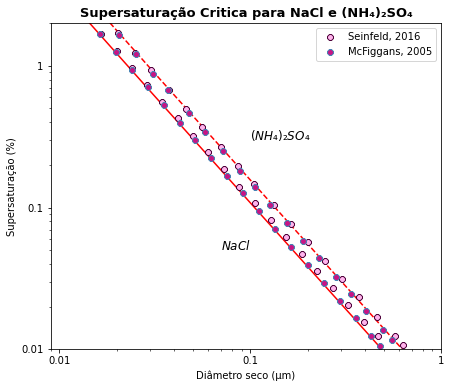

In [224]:
kappa1 = 1.28 # NaCl
kappa2 = 0.61 # (NH₄)₂SO₄
T = 293. # K
Dd = np.linspace(1e-8, 1e-6)

sc1 = np.zeros(len(Dd))
sc2 = np.zeros(len(Dd))
for i in range(len(Dd)):
    sc1[i] = sc(T, Dd[i], kappa1, approx=True)
    sc2[i] = sc(T, Dd[i], kappa2, approx=True)

fig = plt.figure()
fig.set_size_inches(7,6)    
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
# Defining labels
label_sc1= r'$NaCl$'
plt.annotate(label_sc1, (0.7e-7, 0.05e-2), size=12)   
label_sc2= r'$(NH₄)₂SO₄$'
plt.annotate(label_sc2, (1e-7, 0.3e-2), size=12)

scale_x = 1e-6 # meters to micrometers
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
ax.xaxis.set_major_formatter(ticks_x)
scale_y = 1e-2 # to %
ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
#Plot    
plt.plot(Dd, sc1, color= 'red')
plt.plot(Dd, sc2, ls='--', color= 'red')
plt.xlabel('Diâmetro seco (µm)')
plt.ylabel("Supersaturação (%)")
plt.title("Supersaturação Critica para NaCl e (NH₄)₂SO₄", fontsize = 13, fontweight="bold")
plt.axis(xmin=0.9e-8,xmax=1e-6,ymin=0.01e-2, ymax=2e-2)
#Verificação
data1 = np.genfromtxt("scurva1.csv", delimiter=";", names=["x", "y"])
plt.plot(data1['x'], data1['y'], '8', ms = 7, mec = '#4d0039', mfc = '#ffb3ec', label='Seinfeld, 2016')
data2 = np.genfromtxt("scurva2.csv", delimiter=";", names=["x", "y"])
plt.plot(data2['x'], data2['y'], '8', ms = 7, mec = '#4d0039', mfc = '#ffb3ec')
data3 = np.genfromtxt("mcurva1.csv", delimiter=";", names=["x", "y"])
plt.plot(data3['x'], data3['y'], '8', ms = 7, mec = '#4682B4', mfc = '#C71585', label='McFiggans, 2005')
data4 = np.genfromtxt("mcurva2.csv", delimiter=";", names=["x", "y"])
plt.plot(data4['x'], data4['y'], '8', ms = 7, mec = '#4682B4', mfc = '#C71585')

plt.legend()
plt.show()

---
Utilizando a aproximação da supersaturação crítica reproduziu-se a fig. 3.2 na pg. 59 de [[Araujo 2017](#Araujo)].

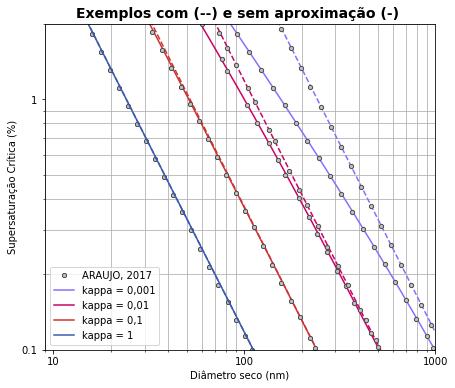

9.41 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [225]:
%%timeit -r 1 -n 1
kappa1 = 0.001
kappa2 = 0.01
kappa3 = 0.1
kappa4 = 1
T = 298.15
Dds = np.linspace(0.5e-8, 1e-6, 10000)    

sc1 = np.zeros(len(Dds))
sc2 = np.zeros(len(Dds))
sc3 = np.zeros(len(Dds))
sc4 = np.zeros(len(Dds))
sc5 = np.zeros(len(Dds))
sc6 = np.zeros(len(Dds))
sc7 = np.zeros(len(Dds))
sc8 = np.zeros(len(Dds))

for i in range(len(Dds)):
    sc1[i] = sc(T, Dds[i], kappa1)
    sc2[i] = sc(T, Dds[i], kappa1, approx=True)
    sc3[i] = sc(T, Dds[i], kappa2)
    sc4[i] = sc(T, Dds[i], kappa2, approx=True)
    sc5[i] = sc(T, Dds[i], kappa3)
    sc6[i] = sc(T, Dds[i], kappa3, approx=True)
    sc7[i] = sc(T, Dds[i], kappa4)
    sc8[i] = sc(T, Dds[i], kappa4, approx=True)
fig = plt.figure()
fig.set_size_inches(7,6)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(0.1e-2, 2e-2)
ax.set_xlim([0.9e-8,1e-6]) 

scale_x = 1e-9 # meters to micrometers
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
ax.xaxis.set_major_formatter(ticks_x)
scale_y = 1e-2 # to %
ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale_y))
ax.yaxis.set_major_formatter(ticks_y)

data1 = np.genfromtxt("curva1.csv", delimiter=";", names=["x", "y"])
plt.plot(data1['x'], data1['y'], '8', ms = 5, mec = '#4F4F4F', mfc = '#C0C0C0')
plt.plot(Dds, sc1, color= '#8470FF') 
plt.plot(Dds, sc3, color= '#CC0066') 
plt.plot(Dds, sc5, color= '#CD3333') 
plt.plot(Dds, sc7, color= '#3D59AB') 
plt.plot(Dds, sc2, ls='--', color= '#8470FF')# aproximation
plt.plot(Dds, sc4, ls='--', color= '#CC0066')# aproximation
plt.plot(Dds, sc6, ls='--', color= '#CD3333')# aproximation
plt.plot(Dds, sc8, ls='--', color= '#3D59AB')# aproximation

plt.xlabel('Diâmetro seco (nm)')
plt.ylabel("Supersaturação Crítica (%)")
plt.title("Exemplos com (--) e sem aproximação (-) ", fontsize = 14, fontweight="bold")


data2 = np.genfromtxt("curva2.csv", delimiter=";", names=["x", "y"])
plt.plot(data2['x'], data2['y'], '8', ms = 5, mec = '#4F4F4F', mfc = '#C0C0C0')

data3 = np.genfromtxt("curva3.csv", delimiter=";", names=["x", "y"])
plt.plot(data3['x'], data3['y'], '8', ms = 4.5, mec = '#4F4F4F', mfc = '#C0C0C0')

data4 = np.genfromtxt("curva4.csv", delimiter=";", names=["x", "y"])
plt.plot(data4['x'], data4['y'], '8', ms = 4.5, mec = '#4F4F4F', mfc = '#C0C0C0')

data5 = np.genfromtxt("curva5.csv", delimiter=";", names=["x", "y"])
plt.plot(data5['x'], data5['y'], '8', ms = 4.5, mec = '#4F4F4F', mfc = '#C0C0C0')

data6 = np.genfromtxt("curva6.csv", delimiter=";", names=["x", "y"])
plt.plot(data6['x'], data6['y'], '8', ms = 4.5, mec = '#4F4F4F', mfc = '#C0C0C0')

plt.grid(True, which="both", ls="-")
plt.grid()
lgd = plt.legend(["ARAUJO, 2017","kappa = 0,001" , "kappa = 0,01", "kappa = 0,1", "kappa = 1"],
                 loc='lower left')
plt.show()

---
[[Petters and Kreidenweis 2007](#P&K)] apresentam na pg. 1964 uma forma aproximada para obter a saturação e o diâmetro critico das curvas de Köhler:  

\begin{equation}
    \begin{cases}
    D_c = \sqrt{\frac{3 \kappa D^3}{A}}\\[0.2cm]
    A = \frac{4\sigma_w M_w}{RT\rho_w}    
    \end{cases}
    \label{eq12}
\end{equation}  


In [226]:
def Dc (T, Dd, kappa, approx=False):   
    if approx:
        A = (4.0 * Mw * sigma_w(T)) / (R * T * rho_water(T))  
        Dc = np.sqrt((3.0 * kappa * (Dd)**3) / A)
    else:
        neg_seq = lambda D: -1.0 * seq(D, Dd, T, kappa)
        out = fminbound(neg_seq, Dd, Dd * 1e4, xtol=1e-10, full_output=True, disp=0)
        Dc = out[0]
    
    return Dc

___
<a class="anchor" id="s3"></a>
## 3. Distribuições

Abaixo segue a implementação feita para descritização dos diâmetros

In [227]:
def D_discr (Dmin, Dmax, n_bins):
    D_discr = np.array(np.geomspace(Dmin, Dmax, n_bins +1))    
    return D_discr

Na pg. 343 de [[Seinfeld and Pandis 2016](#S&P)] é descrita a destribuição de tamanhos dos aerossóis atmosfericos.  

\begin{equation}
    \begin{cases}
    n_N(D) = \frac{N_i}{2 \pi ^{1/2}log\, \sigma_i}exp \left ( \frac{-(log(D) - log(\bar{D_i}))^2}{2log^2\,\sigma_i} \right )\\[0.4cm]
    n_N(D) = \sum_{i=1}^{n} \frac{N_i}{2 \pi ^{1/2}log\, \sigma_i}exp \left ( \frac{-(log(D) - log(\bar{r_i}))^2}{2log^2\,\sigma_i} \right )\\[0.4cm]      
    \end{cases}
    \label{eq13}
\end{equation}  

onde $N_i$ é a concentração de aerossois, $\bar{D_i}$ é o diâmetro médio e $\sigma_i$ é o desvio padrão.

In [228]:
def lognormal (D,N,sd,Dmed,mode='pdf'):
    if mode == 'pdf':      
        a = N / (np.sqrt(2.0 * np.pi) * np.log10(sd))
        b = ((np.log10(D / Dmed))**2) / (2.0 * (np.log10(sd))**2)
        lognormal = a * np.exp(-b) * 1e6 # cm^-3 -> m^-3
    elif mode == 'cdf':
        a = (np.log(D / Dmed)) / (np.sqrt(2.0) * np.log(sd))
        lognormal = (N / 2.0) * (1.0 + erf(a)) * 1e6 # cm^-3 -> m^-3
    return lognormal

A soma de $n$ distribuições lognormais é dada como a multi-lognormal:

In [229]:
def Mult_lognormal (D,Ns,sds,Dmeds,mode='pdf'):    
    n = len(Ns)
    Mult_lognormal = 0
    if mode == 'pdf':
        for i in range(n):
            a = Ns[i] / (np.sqrt(2.0 * np.pi) * np.log10(sds[i]))
            b = ((np.log10(D / Dmeds[i]))**2) / (2.0 * (np.log10(sds[i]))**2)
            Mult_lognormal += a * np.exp(-b) * 1e6 # cm^-3 -> m^-3
    elif mode == 'cdf':
        for i in range(n):
            a = (np.log(D / Dmeds[i])) / (np.sqrt(2.0) * np.log(sds[i]))
            Mult_lognormal += (Ns[i]/2.0) * (1.0 + erf(a))*1e6 # cm^-3 -> m^-3
    return Mult_lognormal

Reprodução da fig. 7.1 apresentada na pg. 170 de [[Araujo 2017](#Araujo)].

In [230]:
# Unica moda
Dmed = 140
sd = 1.70
nbins = 300  # Número de bins
Dmin = Dmed/sd**5
Dmax = Dmed*sd**5
Nt = 300 #cmˆ3

D_disc = D_discr (Dmin, Dmax, nbins)
lognormal1 = lognormal (D_disc,Nt,sd,Dmed)

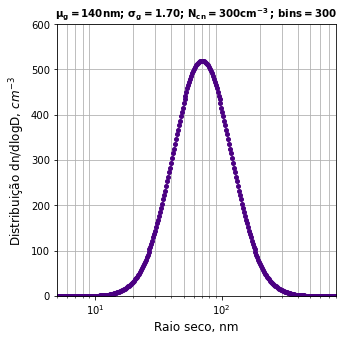

In [231]:
plt.rcParams["figure.figsize"] = (5,5)

plt.xscale('log')
plt.ylim(0, 600)
plt.xlim(5, 8e2)

plt.xlabel('Raio seco, nm', fontsize = 12)
plt.ylabel("Distribuição dn/dlogD, $cm^{-3}$", fontsize = 12)
plt.title(r"$\bf{\mu_{g}= 140nm;\, \sigma_{g}=1.70;\, N_{cn}=300cm^{-3}\,;\, bins=300}$", fontsize = 10.2)
plt.grid(True, which="both", axis='x')
plt.grid()

plt.plot(D_disc/2, lognormal1/1e6, color='#4B0082', ms=4, marker = 'o', linestyle="None" )
plt.savefig("Mcf_distr", dpi=600, facecolor='w')
plt.show()


___
<a class="anchor" id="s4"></a>
## Modelo de crescimento de uma população de gotas 

O crescimento por difusão e evaporação de uma partículas é dado por [[Seinfeld and Pandis 2016](#S&P)] na pg.725:

\begin{equation}
    \begin{cases}
    \frac{dD_p}{dt} =\frac{1}{D_p}(4[S - S{eq}])\bigg/ \frac{\rho_w RT}{p_{vs}D'_{v}M_w}+\frac{L\rho_w[(LM_w/RT)-1]}{k'_aT}  
    \end{cases}
    \label{eq13}
\end{equation}  


In [232]:
def dDp_dt(Dp, t, Dd, T, kappa, Satm, P):
   
    rho = rho_a
    S_seq = Seq(D, Dd, T, kappa)
    delta_S = Satm - S_seq
    d_v = Dv(T, D, P, accom=ac)
    k_a = ka (T, rho, D, accom=at)
    
    
    den1 = (rho_water(T) * R * T) / (es(T) * d_v * Mw)
    den2 = ((L * rho_water(T)) / (k_a * T)) * ((L * Mw) / (T * R) - 1)
    denom = den1 + den2
    
    dDp_dt = (1/Dp) * ((4 * delta_S) / denom)
    
    return dDp_dt


#Falta colocar os plot's

### ODE's:

In [233]:
def dzdt (V):
    dzdt = V
    return dzdt

A pressão é dada por [[Rothenberg and Wang 2016](#D&C)] na pg.1270:

\begin{equation}
    \frac{dP}{dt} =\frac{-gPV}{R_dT_v}  
    \label{eq14}
\end{equation}  

In [234]:
def dPdt (P,V,T,wv,s):    
    dPdt = (-1.0 * g * P * V ) / (Rd * Tv(T,wv,s))     
    return dPdt

A temperatura é dada por [[Seinfeld and Pandis 2016](#S&P)] na pg.722:

\begin{equation}
    \frac{dT}{dt} =\frac{-gV}{C_p}-\frac{L}{C_p}\frac{dw_v}{dt}  
    \label{eq15}
\end{equation}

In [235]:
def dTdt (V,dwvdt):
    dTdt = ((-g * V) / Cp) - ((L * dwvdt) / Cp)
    return dTdt

A taxa de mistura de vapor de água é dada por [[Seinfeld and Pandis 2016](#S&P)] na pg.722:

\begin{equation}
    \frac{dw_v}{dt} + \frac{dw_L}{dt} = 0 
    \label{eq16}
\end{equation}

In [236]:
def dwvdt (dwcdt,dwidt):
    dwvdt = -1.0 * (dwcdt + dwidt)
    return dwvdt

A taxa de mistura de vapor de água é dada por [[Seinfeld and Pandis 2016](#S&P)] na pg.726:

\begin{equation}
    \frac{dw_L}{dt} = \frac{\rho_w}{\rho_a} \frac{\pi}{6} \sum_{i=1}^{n}\, N_i D_{p,i}^3\frac{dD}{dt} 
    \label{eq17}
\end{equation}

In [237]:
def dwcdt (Ni,D,dDdt,P,T,s,wv):  
    dwcdt = dDdt*(Ni * (D)**3) *((np.pi*rho_water(T))/6*(P/Rd*Tv(T,wv,s)))  
    return dwcdt 

In [238]:
def dwidt ():
    dwidt = 0
    return dwidt

A taxa de mistura de vapor de água é dada por [[Seinfeld and Pandis 2016](#S&P)] na pg.729:

\begin{equation}
    \frac{ds}{dt} = \left ( \frac{gM_wL}{C_pRT^2} - \frac{gM_a}{RT} \right )V - \left ( \frac{P M_a}{e_s M_w} + \frac{L^2M_w}{C_pRT^2} \right )
    \frac{dw_L}{dt}
    \label{eq17}
\end{equation}

In [239]:
def dsdt (T,P,V,dwcdt):
    alpha = (g*Mw*L) / (Cp*R*(T**2)) - (g*Ma)/(R*T)
    gamma = (P*Ma) / (es(T) * Mw) + (Mw*(L**2)) / (Cp*R*(T**2)) 
    dsdt = (alpha*V) - (gamma*dwcdt)
    return dsdt

A taxa de mistura de vapor de água é dada por [[Pruppacher and Klett 2011](#P&K)] na pg.729:

\begin{equation}
   \begin{cases}
   \frac{dD_i}{dt} = \frac{G}{D_i/2}(s - s_{eq})  \\[0.4cm]
   G = \left \{ \frac{\rho_w RT}{e_s D'_v M_w} + \frac{L \rho_w[(L M_w/RT) - 1]}{k'_aT}  \right \}^{-1}
   \end{cases}
    \label{eq18}
\end{equation}


In [240]:
def dDdt(D,Dd,T,P,s,kappa,accom):
    #rho = rho_air(P, T, s, wv, dry=False)
    D_v = Dv(T, D, P, accom)
    k_a = ka(T, D, rho_a)

    G_a = (rho_water(T) * R * T) / (es(T) * D_v * Mw)
    G_b = (L * rho_water(T) * ((L * Mw / (R * T)) - 1.0)) / (k_a * T)
    G = 1.0 / (G_a + G_b)
    s_eq = seq(D,Dd,T,kappa)
    delta_s = s - s_eq

    dDdt = (G / (D/2)) * delta_s   
    return dDdt

In [241]:
def dYdt (Y, t, nD, Dd_array, N_array, V, kappas_array, accom=ac):
    
    z, P, T, wv, wc, wi, s = Y[:nsv]
    Ds = np.asarray(Y[nsv:])
    
    dz_dt = dzdt(V)
    dP_dt = dPdt (P,V,T,wv,s)
    dDs_dt = np.zeros(nD)
    dwc_dt = 0.0
    for i in range(nD):
        D = Ds[i]
        Dd = Dd_array[i]
        kappa = kappas_array[i] 
        dD_dt = dDdt(D,Dd,T,P,s,kappa,accom)
        Ni = N_array[i]
        dwc_dt += dwcdt (Ni,D,dD_dt,P,T,s,wv)
        dDs_dt[i] = dD_dt
    dwi_dt = dwidt()
    dwv_dt = dwvdt(dwc_dt,dwi_dt)
    dT_dt = dTdt(V,dwv_dt)
    ds_dt = dsdt (T,P,V,dwc_dt)
    
    dYdt = np.zeros(nD + nsv)
    dYdt[:nsv] = dz_dt, dP_dt, dT_dt, dwv_dt, dwc_dt, dwi_dt, ds_dt
    dYdt[nsv :] = dDs_dt[:]
    
    return dYdt 

Retirado do paper: Droplet activation parameterization: the population-splitting
concept revisited, formulas NCD Appendix B

In [242]:
def NCD(v, N):
    sd, Dmed = 1.35, 60e-9
    N_array = lognormal(Dd_array, N, sd, Dmed)

    y = odeint(dYdt, y0, t, 
            args=(nD, Dd_array, N_array, v, kappas_array, accom,))
    ss = np.max(y[0:,6])
    
    Ncd = log_at(ss, Dmed, sd, N, kappa, sgi=None, approx=True)
    
    return Ncd

Paper: Droplet activation parameterization: the population-splitting concept revisited - Appendix B- eq. B1 e B2, pg.2354

In [243]:
def log_at(smax, Dmed, sd, Nt, kappa, sgi=None, approx=True):
    if not sgi:
        sgi = sc (T, Dmed, kappa, approx=False)    
    ui = 2.0*np.log10(sgi/ smax) / (3.0 * np.sqrt(2)*np.log10(sd))
    #cumulative CCN spectrum
    N_act = (Nt/2)*erfc(ui)   
    
    return N_act

#Plots

In [244]:
#%%timeit -r 1 -n 1
Dg = 140e-9
sd = 1.70
Dmin, Dmax = 2.8e-8, Dg*(sd**5) 
nD = 300 # Número de bins
Dd_array = D_discr(Dmin, Dmax, nD - 1)
kappa = 0.61
# Definition of initial state
y0 = np.zeros(nD + nsv)
z0, P0, T0, wv0, wc0, wi0, s0 = 1e3, 1e5, 300.0, 0.0, 0.0, 0.0, -0.05
y0[:nsv] = z0, P0, T0, wv0, wc0, wi0, s0
# Finding critical diameters
D_crit = np.zeros(len(Dd_array))
for i in range(len(Dd_array)):    
    D_crit[i] = Dc(T0, Dd_array[i], kappa)   
 
y0[nsv:] = D_crit
# Time discretization
t = np.array(np.linspace(0, 1000.0, 2000))
# Distribution of initial dry diameters
N, sd, Dmed = 300, 1.7, 140e-9
N_array = lognormal(Dd_array, N, sd, Dmed)
# Defining additional odes arguments
V = 0.5
accom = 1
kappas_array = np.zeros(nD)
for i in range (nD):
    kappas_array[i] = kappa
    
# Solving odes coupled system
y1 = odeint(dYdt, y0, t, 
            args=(nD, Dd_array, N_array, V, kappas_array, accom,)) 


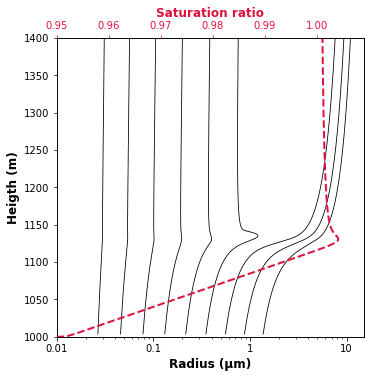

In [245]:
## Plotar as duas curvas    
#separate the figure object and axes object
# from the plotting object
fig, ax1 = plt.subplots()
fig.set_figwidth(5.5)
fig.set_figheight(5.5)
plt.xscale('log')

scale_x = 1e-6 # meters to micrometers
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
ax1.xaxis.set_major_formatter(ticks_x)
##Plot
# Duplicate the axes with a different x axis
# and the same y axis
ax2 = ax1.twiny() # ax2 and ax1 will have common y axis and different x axis

# plot the curves on axes 1, and 2, and get the axes handles
for i in range (nsv, nD):
    if i%30== 0:
        curve1, = ax1.plot(((y1[15:,i]/2)), y1[15:,0], color='black', lw=0.8)

curve2, = ax2.plot(y1[:,6]+1, y1[:,0],'--', color='#DC143C', lw=2)

# Make a curves list to access the parameters in the curves
curves = [curve1, curve2]

# x axis labels via the axes
ax1.set_xlabel("Radius (μm)", color=curve1.get_color(),fontsize = 12, fontweight="bold")
ax2.set_xlabel("Saturation ratio", color=curve2.get_color(),fontsize = 12, fontweight="bold")
# y axis label via the axes
ax1.set_ylabel("Heigth (m)", color=curve1.get_color(),fontsize = 12, fontweight="bold")
# y ticks - make them coloured as well
ax1.tick_params(axis='y', colors=curve1.get_color())
# x axis ticks via the axes
ax1.tick_params(axis='x', colors=curve1.get_color())
ax2.tick_params(axis='x', colors=curve2.get_color())

plt.axis(ymin=1e3,ymax=1.4e3 )
ax2.set_xlim([95e-2, 100.9e-2])
ax1.set_xlim([0.01e-6, 15e-6])

#plt.savefig("Mcf_princ_en", dpi=600, facecolor='w')
plt.show()

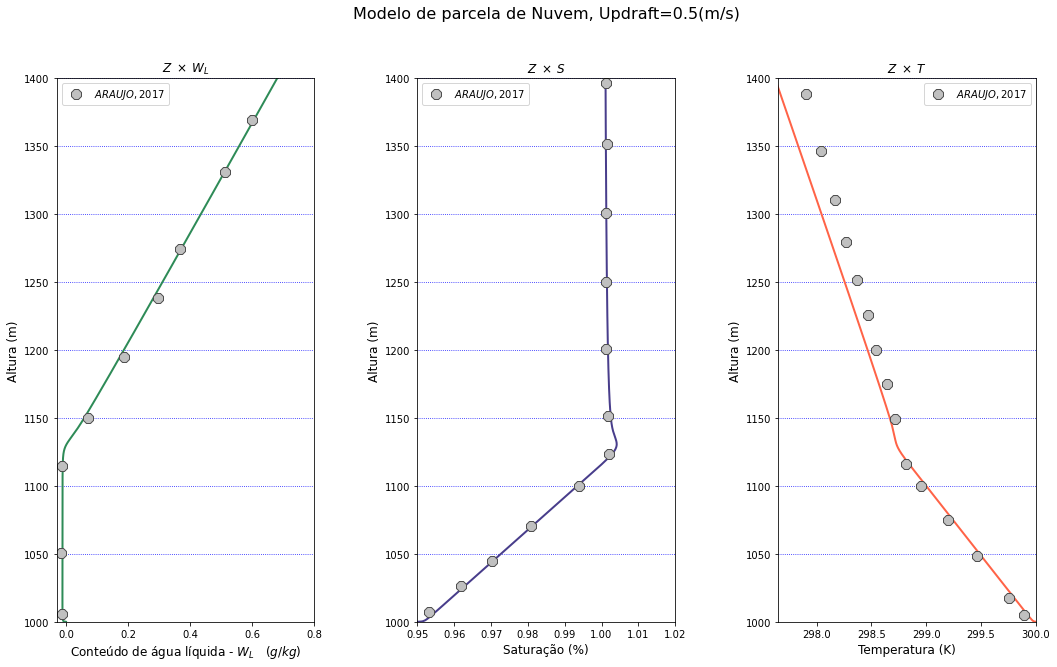

In [246]:
fig,axs=plt.subplots(1,3,constrained_layout=False, figsize=(17,10))
fig.suptitle('Modelo de parcela de Nuvem, Updraft=0.5(m/s)', fontsize=16)

#Plot height vs wv
#subplot(0)
axs[0].plot(y1[:,4]*1e3, y1[:,0], color="#2E8B57",lw=2)
axs[0].set_title(r"$Z\; \times \; W_{L}$",fontsize = 12)
axs[0].set_ylabel("Altura (m)",fontsize = 12)
axs[0].set_xlabel(r"Conteúdo de água líquida - $W_{L}\quad (g/kg)$",fontsize = 12)
axs[0].set_xlim(-0.03,0.8)
axs[0].set_ylim(1e3,1.4e3)
axs[0].grid(axis='y',linestyle='dotted', color='b')
data = np.genfromtxt("wc.txt", delimiter=";", names=["z", "wc"])
axs[0].plot(data['z'], data['wc'], '8', ms = 10, mec = '#4F4F4F', mfc = '#C0C0C0', label='$ARAUJO, 2017$')
axs[0].legend(loc='best')


#Plot height vs supersaturation
#subplot(1)
axs[1].plot(y1[0:,6]+1, y1[0:,0], color='#483D8B',lw=2)
axs[1].set_title(r"$Z\; \times \; S$",fontsize = 12)
axs[1].set_ylabel("Altura (m)",fontsize = 12)
axs[1].set_xlabel("Saturação (%)",fontsize = 12)
axs[1].set_xlim(0.95,1.02)
axs[1].set_ylim(1e3,1.4e3)
axs[1].grid(axis='y',linestyle='dotted', color='b')
data1 = np.genfromtxt("sat.txt", delimiter=";", names=["z", "S"])
axs[1].plot(data1['z'], data1['S'], '8', ms = 10, mec = '#4F4F4F', mfc = '#C0C0C0', label='$ARAUJO, 2017$')
axs[1].legend(loc='best')

#Plot height vs Temperature
#subplot(2)
axs[2].plot(y1[0:,2], y1[0:,0], color='#FF6347',lw=2)
axs[2].set_title(r"$Z\; \times \; T$",fontsize = 12)
axs[2].set_ylabel("Altura (m)",fontsize = 12)
axs[2].set_xlabel("Temperatura (K)",fontsize = 12)
axs[2].set_xlim([297.65, 300])
axs[2].set_ylim([1e3, 1.4e3])
axs[2].grid(axis='y',linestyle='dotted', color='b')
data2 = np.genfromtxt("temp.txt", delimiter=";", names=["z", "T"])
axs[2].plot(data2['z'], data2['T'], '8', ms = 10, mec = '#4F4F4F', mfc = '#C0C0C0', label='$ARAUJO, 2017$')
axs[2].legend(loc='best')

plt.subplots_adjust(left=0.1, right=0.9, wspace=0.4, hspace=4)
#plt.savefig("Mcf_compl", dpi=600, facecolor='w')
plt.show()

In [247]:
smax = np.max(y1[0:,6]+1)
print("A Saturação Máxima atingida foi: {:.3f}%".format((smax)*100))
print("A Supersaturação Máxima atingida foi: {:.3f}%".format((smax-1)*100))

# Altura do maximo da supersaturação (base da nuvem)
q = y1[0:,6] #ss
z = y1[0:,0] #h
z1 = interp1d(q, z)
result = z1(np.max(y1[0:,6]))
print("Altura correspondente a supersaturação máxima: {:.2f}m ".format((result)))

A Saturação Máxima atingida foi: 100.413%
A Supersaturação Máxima atingida foi: 0.413%
Altura correspondente a supersaturação máxima: 1130.82m 


In [248]:
# Concentração de gotas ativadas e porcentagem de ativação (fração de ativação)
smax_1 = np.max(y1[0:,6])
N, sd, Dmed = 300, 1.7, 140e-9
kappa = 0.61

N_act = log_at(smax_1, Dmed, sd, N, kappa, sgi=None, approx=True)
act_frac = N_act/N

print("A concentração de gotas ativadas foi: {:.2f} cmˆ3".format((N_act)))
print("A porcentagem de ativação foi de: {:.2f}% ".format((act_frac*100)))

A concentração de gotas ativadas foi: 290.38 cmˆ3
A porcentagem de ativação foi de: 96.79% 


In [249]:
#Erro percentual entre o meu resultado e do Alex
a = 89/100

erro_p = ((act_frac - a)/a)*100
print("{:.2f}%".format(erro_p))
c = (y1[0:,6]+1, y1[0:,0])


8.76%


Reutter et al.

In [250]:
# =============================================================================
# Plot Fig 3 Reutter
# =============================================================================

Dg = 60e-9
sd = 1.35
Dmin, Dmax = 2e-8, Dg*(sd**4) 
nD = 90 # Número de bins
Dd_array = D_discr(Dmin, Dmax, nD - 1)
kappa = 1.28 #NaCl
# Definition of initial state
y0 = np.zeros(nD + nsv)
z0, P0, T0, wv0, wc0, wi0, s0 = 671.5, 950e2, 285.2, 0.0, 0.0, 0.0, 0.0
y0[:nsv] = z0, P0, T0, wv0, wc0, wi0, s0
# Finding critical diameters
D_crit = np.zeros(len(Dd_array))
for i in range(len(Dd_array)):    
    D_crit[i] = Dc(T0, Dd_array[i], kappa)   
 
y0[nsv:] = D_crit
# Time discretization
t = np.array(np.linspace(0, 1000.0, 70000))

accom = 1
kappas_array = np.zeros(nD)
for i in range (nD):
    kappas_array[i] = kappa

In [ ]:
h = 5
T = T0
v = np.linspace(0.5,3.5, num=h)
N = np.linspace(800,3600, num=h)

b = np.zeros((h,h))
for i in range(h):
    for j in range(h):
        b[i,j] = NCD(v[i],N[j])

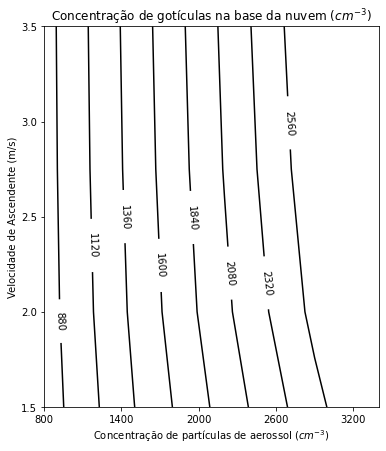

In [47]:
fig=plt.figure()
fig.set_size_inches(6,7)
plt.title(r'Concentração de gotículas na base da nuvem $(cm^{-3})$')
plt.xlabel(r'Concentração de partículas de aerossol $(cm^{-3})$')
plt.ylabel('Velocidade de Ascendente (m/s)')
levels = [880, 1120, 1360, 1600, 1840, 2080, 2320, 2560]
contours = plt.contour(N, v, b, levels, colors='black')
manual_locations = [(900,1.95),(1200,2.35),(1400,2.5),(1800,2.25),(2000,2.5),(2200,2.20),(2500,2.15), (2800,3.0)]
plt.clabel(contours, inline=1, fontsize=10,manual=manual_locations)
plt.xticks((800,1400,2000,2600,3200))
plt.yticks((1.5,2.0,2.5,3.0,3.5))
plt.ylim(1.5,3.5)
plt.xlim(800,3400)
#data = np.genfromtxt("reutter_2.txt", delimiter=";", names=["N", "v"])
#plt.plot(data['N'], data['v'], '*', ms = 5, mec = '#337d05', mfc = '#60f702', label='$Reutter, 2009$')

#plt.savefig("reutter_2_100", dpi=600, facecolor='w')
plt.show()

### Referências

#### <mark><a id="S&P"></a> [Seinfeld and Pandis 2016]</mark>  
J. H. Seinfeld and S. N. Pandis, Atmospheric chemistry and physics : from air pollution to climate change. Hoboken, Nj: Wiley, 2016.

#### <mark><a id="Nns"></a> [NENES et al. 2001]</mark>  
A. NENES, S. GHAN, H. ABDUL-RAZZAK, P. Y. CHUANG, and J. H. SEINFELD, “Kinetic limitations on cloud droplet formation and impact on cloud albedo,” Tellus B, vol. 53, no. 2, pp. 133–149, Apr. 2001, doi: 10.1034/j.1600-0889.2001.d01-12.x.

#### <mark><a id="P&K"></a> [Pruppacher and Klett 2011]</mark>  
Pruppacher, Hans R, and James D Klett. 2011. Microphysics of Clouds and Precipitation. Dordrecht ; Heidelberg ; London: Springer, Impr.

#### <mark><a id="W&H"></a> [Wallace and Hobbs 2011]</mark>  
Wallace, John M, and Peter Victor Hobbs. 2011. Atmospheric Science : An Introductory Survey. Amsterdam: Elsevier Acad. Press.

#### <mark><a id="D&C"></a> [Rothenberg and Wang 2016]</mark> 
Rothenberg, Daniel, and Chien Wang. 2016. “Metamodeling of Droplet Activation for Global Climate Models.” Journal of the Atmospheric Sciences 73 (3): 1255–72. https://doi.org/10.1175/jas-d-15-0223.1.

#### <mark><a id="Araujo"></a> [Araujo 2017]</mark>   
Araujo, Alex Sandro Alves de. 2017. “Efeitos de Poluição Urbana Na Higroscopicidade Dos Aerossóis E Na Ativação de Gotas Em Nuvens Quentes Na Amazônia No Âmbito Do Experimento GoAmazon 2014/5,” May. https://doi.org/10.11606/d.43.2017.tde-07062017-155108.

#### <mark><a id="P&K"></a> [Petters and Kreidenweis 2007]</mark>  
Petters, M. D., and S. M. Kreidenweis. 2007. “A Single Parameter Representation of Hygroscopic Growth and Cloud Condensation Nucleus Activity.” Atmospheric Chemistry and Physics 7 (8): 1961–71. https://doi.org/10.5194/acp-7-1961-2007.